In [43]:
import numpy as np
import pandas as pd
import spacy
import re
import pycld2 as cld2
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as snb
from wordcloud import WordCloud, STOPWORDS
import math
from scipy.stats import chi2_contingency, chisquare, chi2
import nltk  
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
from textblob import Word

In [24]:
def clean_tweet(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r"@[A-Za-z0-9]+","", tweet)
    tweet = re.sub(r"#","", tweet)
    tweet = re.sub(r"\ART[\s]+","", tweet) 
    tweet = re.sub(r"https?:\/\/\S+","", tweet)
    tweet = re.sub("(.)\\1{2,}","\\1", tweet)
    tweet = re.sub(r"[^A-Za-z0-9\s]+", "",str(tweet))
    
    return tweet

In [25]:
trump_df = pd.read_csv('hashtag_joebiden.csv', lineterminator='\n')

In [26]:
trump_df.head(5)

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:18,1.316529e+18,#HunterBiden #HunterBidenEmails #JoeBiden #Joe...,0.0,0.0,Twitter for iPad,8.099044e+08,Cheri A. 🇺🇸,Biloximeemaw,"Locked and loaded Meemaw. Love God, my family ...",...,6628.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.517827283
2,2020-10-15 00:00:20,1.316529e+18,@IslandGirlPRV @BradBeauregardJ @MeidasTouch T...,0.0,0.0,Twitter Web App,3.494182e+09,Flag Waver,Flag_Wavers,NaN,...,1536.0,Golden Valley Arizona,46.304036,-109.171431,NaN,United States of America,North America,Montana,MT,2020-10-21 00:00:01.035654566
3,2020-10-15 00:00:21,1.316529e+18,@chrislongview Watching and setting dvr. Let’s...,0.0,0.0,Twitter for iPhone,8.242596e+17,Michelle Ferg,MichelleFerg4,NaN,...,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.553481849
4,2020-10-15 00:00:22,1.316529e+18,#censorship #HunterBiden #Biden #BidenEmails #...,1.0,0.0,Twitter Web App,1.032807e+18,the Gold State,theegoldstate,A Silicon Valley #independent #News #Media #St...,...,390.0,"California, USA",36.701463,-118.755997,NaN,United States of America,North America,California,CA,2020-10-21 00:00:02.071309132


In [27]:
trump_df["tweet"] = trump_df["tweet"].apply(clean_tweet)

In [28]:
trump_df["tweet"]

0         elecciones2020  en florida joebiden dice que d...
1         hunterbiden hunterbidenemails joebiden joebide...
2          this is how biden made his  trumpisnotamerica \n
3          watching and setting dvr lets give him bonus ...
4         censorship hunterbiden biden bidenemails biden...
                                ...                        
776881    stop laying  \nparis and london dont give a fu...
776882                                               biden 
776883    lotan va sortir de sa lthargie et redevenir le...
776884    \n\ncongiuntifuoriregione\n\nsono felice per j...
776885    ik moet zeggen dat ik biden the lesser of two ...
Name: tweet, Length: 776886, dtype: object

In [29]:
trump_tweet = trump_df.drop(columns=['tweet_id','user_id','user_name','user_screen_name',
                                  'user_description','user_join_date','collected_at'])

In [30]:
def detect_lang(tweet):
    try:
        isReliable, textBytesFound, details = cld2.detect(tweet)
        return details[0][0]
    except:
        return "not found"

In [31]:
train_langs = trump_tweet["tweet"].apply(detect_lang)

In [32]:
trump_tweet["lang"] = train_langs

In [33]:
trump_tweet_train = trump_tweet[trump_tweet["lang"] == "ENGLISH"]

In [34]:
len(trump_tweet_train)

526887

In [37]:
trump_tweet_train.head(5)

,created_at,tweet,likes,retweet_count,source,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,lang
2,2020-10-15 00:00:20,this is how biden made his trumpisnotamerica \n,0.0,0.0,Twitter Web App,1536.0,Golden Valley Arizona,46.304036,-109.171431,NaN,United States of America,North America,Montana,MT,ENGLISH
3,2020-10-15 00:00:21,watching and setting dvr lets give him bonus ...,0.0,0.0,Twitter for iPhone,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENGLISH
4,2020-10-15 00:00:22,censorship hunterbiden biden bidenemails biden...,1.0,0.0,Twitter Web App,390.0,"California, USA",36.701463,-118.755997,NaN,United States of America,North America,California,CA,ENGLISH
5,2020-10-15 00:00:23,is this wrong cory bookers brilliant final que...,0.0,0.0,Twitter Web App,4622.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENGLISH
6,2020-10-15 00:00:25,in 2020 nypost is being censorship censored by...,0.0,0.0,Twitter for iPhone,1397.0,"Chicago, Illinois",41.875562,-87.624421,Chicago,United States of America,North America,Illinois,IL,ENGLISH


Text(0.5, 1.0, 'Joe Tweets Word Cloud')

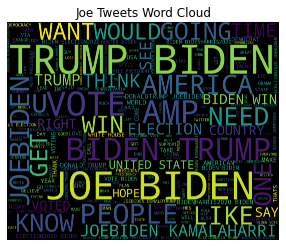

In [38]:
stop_words = set(stopwords.words('english'))
wordcloud = WordCloud(width=5000, height=4000,stopwords=stop_words,random_state = 2016).generate(" ".join([i for i in trump_tweet_train['tweet'].str.upper()]))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Joe Tweets Word Cloud")

In [39]:
def lemm_tweet(tweet, stem=False, lemmatize=False):
    temp_tweet = []
    words = word_tokenize(tweet) 

    # Remove stopwords and stem
    for word in words:
        if not word in stop_words:
            if stem:
                temp_tweet.append(ps.stem(word))
            elif lemmatize:
                temp_tweet.append(Word(word).lemmatize())
            else:
                temp_tweet.append(word)
                
    return temp_tweet


In [40]:
trump_tweet_train.tweet = trump_tweet_train.tweet.apply(lambda x: lemm_tweet(x))

C:\Users\Zack\anaconda3\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [45]:
def sentiment_analysis(df):
    
    # Determine polarity and subjectivity
    df['Polarity'] = df['tweet'].apply(lambda x: TextBlob(' '.join(x)).sentiment.polarity)
    df['Subjectivity'] = df['tweet'].apply(lambda x: TextBlob(' '.join(x)).sentiment.subjectivity)
    
    # Classify overall sentiment
    df.loc[df.Polarity > 0,'Sentiment'] = 1
    df.loc[df.Polarity == 0,'Sentiment'] = 0
    df.loc[df.Polarity < 0,'Sentiment'] = -1
    
    return df

In [46]:
sentiment_analysis(trump_tweet_train)

<ipython-input-45-723e8472946e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Polarity'] = df['tweet'].apply(lambda x: TextBlob(' '.join(x)).sentiment.polarity)
<ipython-input-45-723e8472946e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Subjectivity'] = df['tweet'].apply(lambda x: TextBlob(' '.join(x)).sentiment.subjectivity)
C:\Users\Zack\anaconda3\lib\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

,created_at,tweet,likes,retweet_count,source,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,lang,Polarity,Subjectivity,Sentiment
2,2020-10-15 00:00:20,"[biden, made, trumpisnotamerica]",0.0,0.0,Twitter Web App,1536.0,Golden Valley Arizona,46.304036,-109.171431,NaN,United States of America,North America,Montana,MT,ENGLISH,0.000000,0.000000,0.0
3,2020-10-15 00:00:21,"[watching, setting, dvr, lets, give, bonus, ra...",0.0,0.0,Twitter for iPhone,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENGLISH,0.000000,0.000000,0.0
4,2020-10-15 00:00:22,"[censorship, hunterbiden, biden, bidenemails, ...",1.0,0.0,Twitter Web App,390.0,"California, USA",36.701463,-118.755997,NaN,United States of America,North America,California,CA,ENGLISH,0.000000,0.000000,0.0
5,2020-10-15 00:00:23,"[wrong, cory, bookers, brilliant, final, quest...",0.0,0.0,Twitter Web App,4622.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENGLISH,0.133333,0.966667,1.0
6,2020-10-15 00:00:25,"[2020, nypost, censorship, censored, twitter, ...",0.0,0.0,Twitter for iPhone,1397.0,"Chicago, Illinois",41.875562,-87.624421,Chicago,United States of America,North America,Illinois,IL,ENGLISH,-0.148810,0.678571,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776874,2020-11-08 23:59:06,"[biden, camps, announcement, idlib, merely, ai...",1.0,0.0,Twitter Web App,3019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENGLISH,-0.500000,0.500000,-1.0
776876,2020-11-08 23:59:16,"[mr, biden, tear, wall, mexico, whats, never, ...",1.0,0.0,Twitter for iPhone,444.0,"Auckland, NZ",-36.852095,174.763180,Auckland,New Zealand,Oceania,Auckland,AUK,ENGLISH,0.311111,0.611111,1.0
776877,2020-11-08 23:59:32,"[nyt, beratalbayraks, departure, may, also, si...",3.0,0.0,Twitter for iPhone,14770.0,London/ Istanbul/Izmir /Beirut,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENGLISH,0.000000,0.000000,0.0
776878,2020-11-08 23:59:33,"[thank, support, hard, work, biden, harris, ti...",2.0,1.0,Twitter for Android,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENGLISH,-0.291667,0.541667,-1.0


In [48]:
trump_tweet_train.to_csv('joe_tweet_senti.csv', index = False)

In [ ]:
predictions

In [ ]:
trump_tweet_train["Polarity"].mean()

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(train_data, targets, test_size=0.33)
model.fit(X_train, Y_train)


In [ ]:
def check_model_metrics(model, test_data, test_targets):
    y_pred = model.predict(test_data)

    print("ACCURACY:")
    print(metrics.accuracy_score(test_targets, y_pred)*100)

    print("\nCONFUSSION MATRIX")
    print(confusion_matrix(test_targets, y_pred))

    print("\nCLASSIFICATION REPORT")
    print(classification_report(test_targets, y_pred))

In [ ]:
train_data = trump_tweet_train['tweet']

In [ ]:
targets = trump_tweet_train["Sentiment"]

In [ ]:
model, x_test, y_test = train_model(train_data, targets)

In [ ]:
trump_tweet_train